In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [20]:
df = pd.read_csv("Adani Stock Market.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Close']].dropna()

In [22]:
# Prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [24]:
# Create sequences for LSTM
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled_data)
split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

In [26]:
# LSTM Model
model_lstm = Sequential([
    LSTM(50, return_sequences=False, input_shape=(60,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32)

pred_lstm = model_lstm.predict(X_test_lstm)
pred_lstm_rescaled = scaler.inverse_transform(pred_lstm)
y_test_rescaled = scaler.inverse_transform(y_test_lstm)


Epoch 1/10


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0991
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0045
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [27]:
# Linear Regression
X_lr = np.arange(len(df)).reshape(-1, 1)
y_lr = df['Close'].values.reshape(-1, 1)
split = int(0.8 * len(df))
model_lr = LinearRegression().fit(X_lr[:split], y_lr[:split])
pred_lr = model_lr.predict(X_lr[split:])

In [28]:
# XGBoost
X_xgb = np.arange(len(df)).reshape(-1, 1)
y_xgb = df['Close'].values
model_xgb = XGBRegressor()
model_xgb.fit(X_xgb[:split], y_xgb[:split])
pred_xgb = model_xgb.predict(X_xgb[split:])


In [29]:
# Evaluation
def evaluate(true, pred, label):
    print(f"\n📊 {label} Performance:")
    print("RMSE:", mean_squared_error(true, pred, squared=False))
    print("MAE:", mean_absolute_error(true, pred))
    print("R² Score:", r2_score(true, pred))

evaluate(y_test_rescaled, pred_lstm_rescaled, "LSTM")
evaluate(y_lr[split:], pred_lr, "Linear Regression")
evaluate(y_xgb[split:], pred_xgb, "XGBoost")


📊 LSTM Performance:
RMSE: 77.28045902481891
MAE: 46.2048177031401
R² Score: 0.9651755280182742

📊 Linear Regression Performance:
RMSE: 1037.7924912907479
MAE: 999.3705507632199
R² Score: -5.257494289878372

📊 XGBoost Performance:
RMSE: 631.022283956748
MAE: 476.66061973147777
R² Score: -1.3134962833609878


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


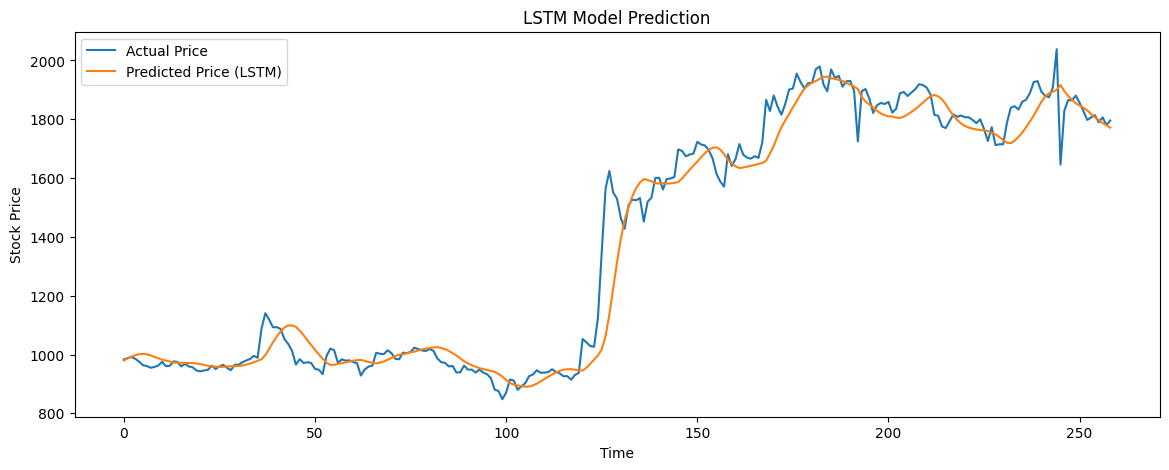

In [35]:
# Plot for LSTM
plt.figure(figsize=(14,5))
plt.plot(y_test_rescaled, label='Actual Price')
plt.plot(pred_lstm_rescaled, label='Predicted Price (LSTM)')
plt.title('LSTM Model Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


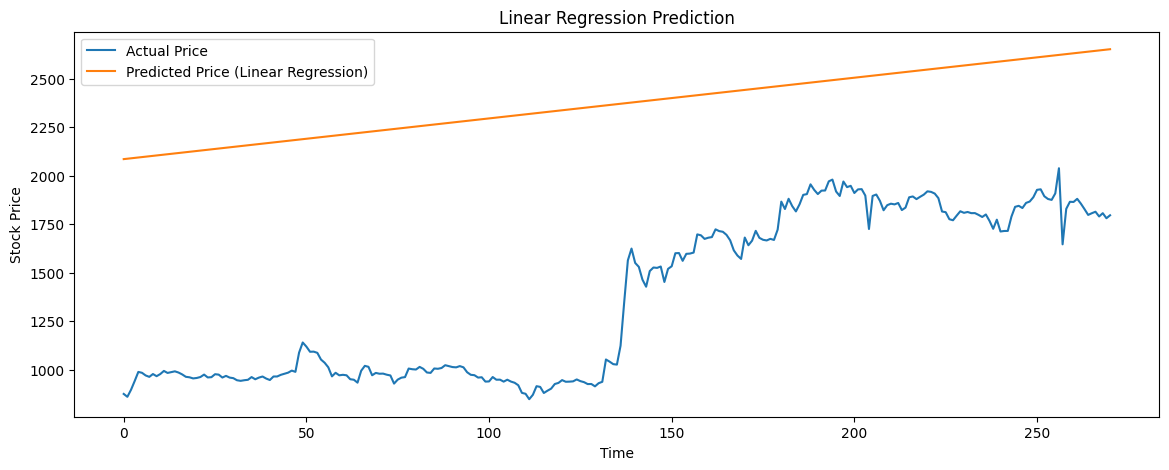

In [37]:
# Plot for Linear Regression
plt.figure(figsize=(14,5))
plt.plot(y_lr[split:], label='Actual Price')
plt.plot(pred_lr, label='Predicted Price (Linear Regression)')
plt.title('Linear Regression Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


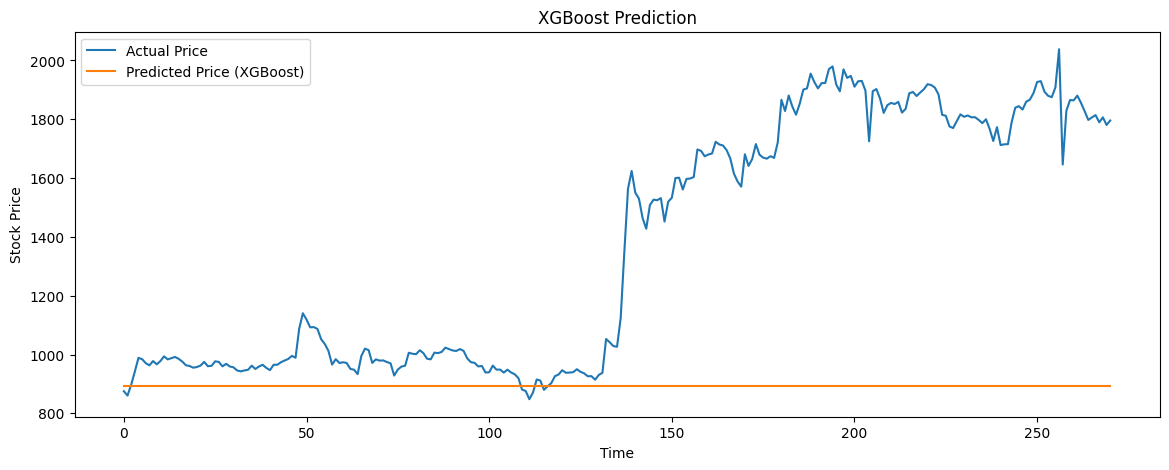

In [39]:
# Plot for XGBoost
plt.figure(figsize=(14,5))
plt.plot(y_xgb[split:], label='Actual Price')
plt.plot(pred_xgb, label='Predicted Price (XGBoost)')
plt.title('XGBoost Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


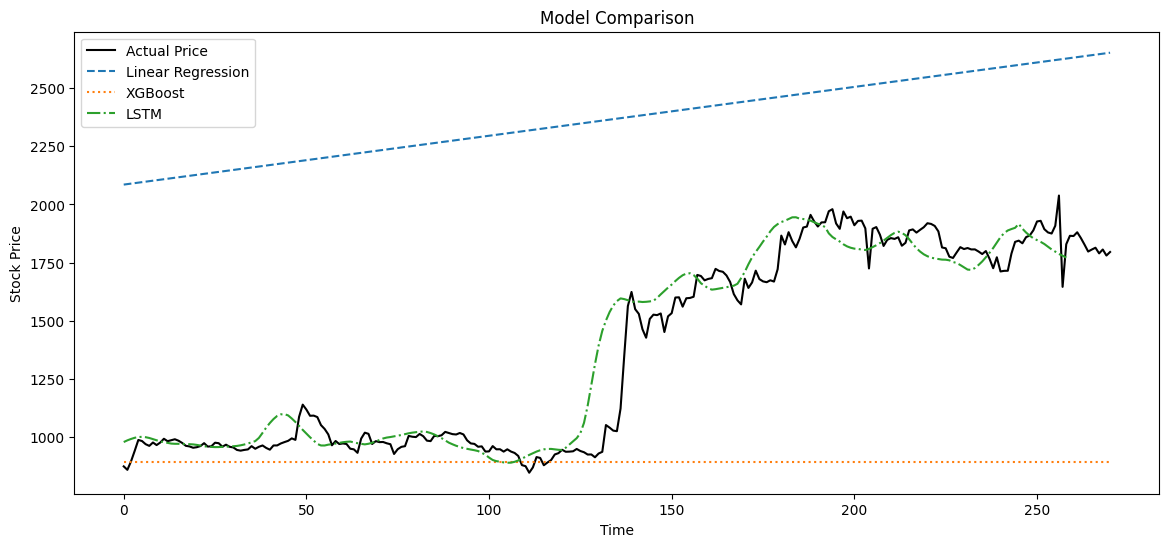

In [41]:
plt.figure(figsize=(14,6))
plt.plot(y_lr[split:], label='Actual Price', color='black')
plt.plot(pred_lr, label='Linear Regression', linestyle='--')
plt.plot(pred_xgb, label='XGBoost', linestyle=':')
plt.plot(pred_lstm_rescaled[:len(pred_lr)], label='LSTM', linestyle='-.')
plt.title('Model Comparison')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()